NOTE: A cleaned implementation of this notebook is implemented in `preprocess.py` for training.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
# !unzip "Datasets/python_dataset.zip" -d "Datasets"
# df = pd.read_csv("Datasets/python_dataset.csv")
# df = df[['code', 'docstring']]
# print(df.shape)
# df.head()

In [4]:
df = pd.read_csv("Datasets/python_Sample_dataset.csv")
df = df[['code', 'docstring']]
print(df.shape)

pd.options.display.max_colwidth = 100
df.head()

(2163, 2)


,code,docstring
0,"root.attributes('-topmost', True)",How to make a window jump to the front?
1,root.lift(),How to make a window jump to the front?
2,"hex(int(''.join([str(int(b)) for b in walls]), 2))",Elegant way to convert list to hex string
3,"hex(sum(b << i for i, b in enumerate(reversed(walls))))",Elegant way to convert list to hex string
4,"print(('Total score for', name, 'is', score))",Print multiple arguments in python


# Preprocessing

In [5]:
df.isna().sum()

code         0
docstring    0
dtype: int64

In [6]:
# df[df['code'].isna()].head()
df.dropna(inplace=True)
df.shape

(2163, 2)

In [7]:
df.dtypes

code         object
docstring    object
dtype: object

In [8]:
def clean_text(text):
    # Split CamelCase characters like ConcatenationOperator to Concatenation Operator
    text = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', str(text))).split()
    text = ' '.join(text)
    
    # Replace tabs, newlines, and carriage returns with a single space
    text = re.sub("(\\t|\\r|\\n)", " ", str(text)).lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r"[<>()|&©ø\[\]\'\",.\}`$\{;@?~*!+=_\//1234567890]", " ", str(text)).lower()
    
    # Remove repeated words
    text = re.sub(r"\b(\w+)(?:\W+\1\b)+", "", str(text)).lower()
    
    # Remove punctuation at the end of a word
    text = re.sub("(\.\s+|\-\s+|\:\s+)", " ", str(text)).lower()
    
    # Remove multiple spaces
    text = re.sub("(\s+)", " ", str(text)).lower()
    
    # Remove single character (any character) between any two spaces
    text = re.sub("(\s+.\s+)", " ", str(text)).lower()

    return text

In [9]:
df['code'] = df['code'].apply(clean_text)
df['docstring'] = df['docstring'].apply(clean_text)
df.head()

,code,docstring
0,root attributes -topmost true,how to make window jump to the front
1,root lift,how to make window jump to the front
2,hex int join str int for in walls,elegant way to convert list to hex string
3,hex sum i for b in enumerate reversed walls,elegant way to convert list to hex string
4,print total score for name is score,print multiple arguments in python


In [56]:
# df['code'] = df['code'].astype(str)
# df['docstring'] = df['docstring'].astype(str)

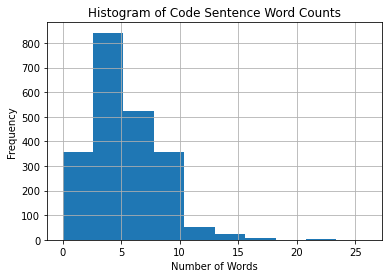

In [10]:
code_word_counts = df['code'].str.split().str.len()
histogram_df = pd.DataFrame({'code_word_count': code_word_counts})

histogram_df.hist(column='code_word_count', bins=10)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Code Sentence Word Counts')
# define fig size
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

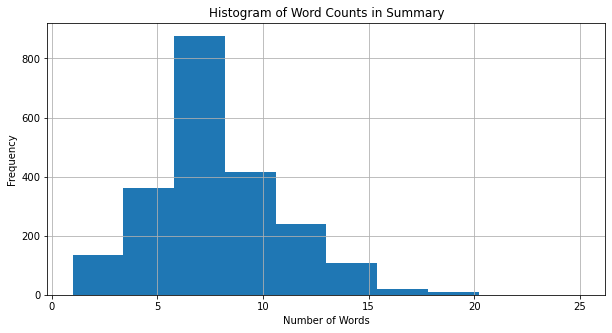

In [11]:
summary_word_counts = df['docstring'].str.split().str.len()
histogram_df = pd.DataFrame({'summary_word_counts': summary_word_counts})

histogram_df.hist(column='summary_word_counts', bins=10)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Summary')
plt.show()

In [12]:
# Deciding max len based on max & quartles
print(np.max(code_word_counts), np.percentile(code_word_counts, 99.9))
print(np.max(summary_word_counts), np.percentile(summary_word_counts, 99))

26 22.0
25 16.0


In [13]:
# TODO: Deciding max len
max_code_len = 100
max_summary_len = 25

Removing rows with greater than max len - outliers?

In [14]:
# Filter only those rows which has codes and summaries within max length
# utilizes boolean indexing and str.len() method to filter t df directly
df = df[(df['code'].str.split().str.len() <= max_code_len) & (df['docstring'].str.split().str.len() <= max_summary_len)]

# Apply start and end markers to the summaries
df['docstring'] = 'sostok ' + df['docstring'] + ' eostok'

df.head()

,code,docstring
0,root attributes -topmost true,sostok how to make window jump to the front eostok
1,root lift,sostok how to make window jump to the front eostok
2,hex int join str int for in walls,sostok elegant way to convert list to hex string eostok
3,hex sum i for b in enumerate reversed walls,sostok elegant way to convert list to hex string eostok
4,print total score for name is score,sostok print multiple arguments in python eostok


In [15]:
# check if there is a blank docstring
# df[df['docstring'] == 'sostok eostok'].head()
df[df['docstring'].str.split().str.len() == 2].head()

,code,docstring


In [16]:
# remove blank summaries that is empty strings (containing only sstok and estok markers)
# df = df[~df['summary'].isin(['sostok eostok'])]

# Tokenisation

**Tokenization** is the process of splitting the text into individual words (tokens).

<!-- toggle -->

<details>
    <summary>Attributes: </summary>

- word_counts: A dictionary of words and their counts.
- word_docs: A dictionary of words and how many documents each appeared in.
- word_index: A dictionary of words and their uniquely assigned integers.
- document_count: An integer count of the total number of documents that were used to fit the Tokenizer.
</details>

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['code']),
    np.array(df['docstring']),
    test_size=0.15,
    random_state=0,
    shuffle=True
)

print("Train: ", x_train.shape)
print("Val: ", x_val.shape)

Train:  (1838,)
Val:  (325,)


**Tokenizing code:**

In [19]:
# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [20]:
print(x_tokenizer.num_words)    # returning None ?
print(x_tokenizer.document_count)  # total number of texts used to fit the tokenizer
print(len(x_tokenizer.word_index))  # unique words => dict of (unique words, token)

None
1838
1471


In [21]:
type(x_tokenizer)

keras.preprocessing.text.Tokenizer

TODO: Infrequent/rarer words are good, no? 
Stop words toh frequent honge hi.

In [22]:
# Check infrequent words in the vocabulary, as it may add noise

threshold = 2 #omit words which occur only two times 
# ( can use 5 thresh in case of larger datasets )

# total_cnt = 0
# cnt_infrequent = 0
# for key, value in x_tokenizer.word_counts.items():   # dict of word and count
#     total_cnt += 1
#     if value < threshold:
#         cnt_infrequent += 1

total_cnt = len(x_tokenizer.word_index)
cnt_infrequent = sum(1 for count in x_tokenizer.word_counts.values() if count < threshold)
    
print("%age of not frequent words in vocabulary: ", (cnt_infrequent / total_cnt) * 100)

%age of not frequent words in vocabulary:  47.58667573079538


In [23]:
print(total_cnt, cnt_infrequent)

1471 700


In [24]:
# Remove the infrequent words
num_words = total_cnt - cnt_infrequent
x_tokenizer = Tokenizer(num_words=num_words)
x_tokenizer.fit_on_texts(list(x_train))

In [25]:
print(x_tokenizer.num_words)    # max no. of words kept in dict
print(x_tokenizer.document_count)  # total number of texts used to fit the tokenizer
print(len(x_tokenizer.word_index))  # unique words => dict of (unique words, token)

771
1838
1471


In [26]:
# Size of vocabulary (+1 for padding token)
x_vocab_size = x_tokenizer.num_words + 1
print("Size of vocabulary in X = {}".format(x_vocab_size))

Size of vocabulary in X = 772


In [27]:
# Convert the code sequences to integer sequences (tokens)
x_train_seqs = x_tokenizer.texts_to_sequences(x_train)
x_val_seqs = x_tokenizer.texts_to_sequences(x_val)

In [28]:
x_train_seqs[:5]

[[4, 233, 522, 523, 152, 27],
 [31, 2, 338, 1, 32, 11, 2, 31, 1, 338],
 [141, 407],
 [77, 94, 23, 38, 19, 153],
 [56, 3]]

In [29]:
# Pad sequences (with 0) to ensure consistent length
x_train = pad_sequences(x_train_seqs,  maxlen=max_code_len, padding='post')
x_val = pad_sequences(x_val_seqs, maxlen=max_code_len, padding='post')

In [30]:
x_train[0]

array([  4, 233, 522, 523, 152,  27,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

**Tokenizing summary:**

In [31]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

threshold = 2    # increase for larger datsets
total_cnt = len(x_tokenizer.word_index)
cnt_infrequent = sum(1 for count in y_tokenizer.word_counts.values() if count < threshold)
num_words = total_cnt - cnt_infrequent

y_tokenizer = Tokenizer(num_words=num_words)
y_tokenizer.fit_on_texts(list(y_train))

y_train_seqs = y_tokenizer.texts_to_sequences(y_train)
y_val_seqs = y_tokenizer.texts_to_sequences(y_val)

y_train = pad_sequences(y_train_seqs,  maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seqs, maxlen=max_summary_len, padding='post')

y_vocab_size = y_tokenizer.num_words + 1
print("Size of vocabulary in Y = {}".format(y_vocab_size))

Size of vocabulary in Y = 936


In [32]:
y_train[0]

array([  1,   6,   5, 138, 228, 770,  19, 771,  17,   3,  13,  26,  34,
         2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [33]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

1838 1838
325 325


TODO:
- Handling **Stop Words** ?
- What happen with **OOVs** ?

*By default, the tokenizer assigns the index 1 to OOV words*

TODO:
Using standard word vectors like **GloVe** instead of basic tokenisation